# Eulerian gridding of GDP trajectories

## Import libraries

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from pyproj import Geod
g = Geod(ellps='WGS84') 

import seaborn as sns

from tqdm import trange

import cartopy.crs as ccrs

from plot_functions import createFigurewithProjection, shapeAxis


## Load data sets

In [30]:
bathy = xr.open_dataset('../data/bathy/GEBCO_02_Dec_2022_8bb5cd71a07e/gebco_2022_n62.0_s59.0_w-49.0_e-40.0.nc')

gdp = xr.open_dataset('../data/GDP/processed_gdp_data.nc')

adsc = xr.open_dataset('../data/ADSC/geo_ekman_daily_gdp.nc').isel(depth=0)

### Create grids

In [32]:
res = 1/4
latmin_study, latmax_study = 59, 62
lonmin_study, lonmax_study = -49, -40
lon_bnd = np.arange(lonmin_study, lonmax_study+res, res)
lat_bnd = np.arange(latmin_study, latmax_study+res, res)

X, Y = np.meshgrid(np.arange(lonmin_study+(res/2), lonmax_study+(res/2), res), np.arange(latmin_study+(res/2), latmax_study+(res/2), res))

U = np.zeros((len(gdp.traj), X.shape[0], X.shape[1]))
V = np.zeros((len(gdp.traj), X.shape[0], X.shape[1]))
U[:,:,:]= np.nan
V[:,:,:]= np.nan


U_ek = np.zeros((len(gdp.traj), X.shape[0], X.shape[1]))
V_ek = np.zeros((len(gdp.traj), X.shape[0], X.shape[1]))
U_ek[:,:,:]= np.nan
V_ek[:,:,:]= np.nan

nb_data = np.zeros((len(gdp.traj), X.shape[0], X.shape[1]))
nb_data[:,:,:]= np.nan

DIST_center = np.zeros((len(gdp.traj), X.shape[0], X.shape[1]))
DIST_center[:,:,:]= np.nan

In [33]:
soon = np.datetime64('2022')
late = np.datetime64('1970')

timestart = []

### Fill the grids

In [37]:
for n_d in trange(len(gdp.traj)):
    
    drifter = gdp.isel(traj=n_d)
    dlon = drifter.lon[~np.isnan(drifter.lon)].values
    dlat = drifter.lat[~np.isnan(drifter.lon)].values
    dtime = drifter.time[~np.isnan(drifter.lon)].values
    drif_u = drifter.u[~np.isnan(drifter.lon)].values
    drif_v = drifter.v[~np.isnan(drifter.lon)].values

    # timestart.append(dtime[0])

    # Save the time bounds
    if dtime[0]<soon:
        soon = dtime[0] 

    if dtime[-1]>late:
        late = dtime[-1] 

    # Loop to compute the velocity grids
    for i in range(len(lon_bnd)-1):
        for j in range(len(lat_bnd)-1):

            if any((dlon>lon_bnd[i]) & (dlon<lon_bnd[i+1]) & (dlat>lat_bnd[j]) & (dlat<lat_bnd[j+1])):

                lon_pts = dlon[(dlon>lon_bnd[i]) & (dlon<lon_bnd[i+1]) & (dlat>lat_bnd[j]) & (dlat<lat_bnd[j+1])]
                lat_pts = dlat[(dlon>lon_bnd[i]) & (dlon<lon_bnd[i+1]) & (dlat>lat_bnd[j]) & (dlat<lat_bnd[j+1])]

                lon_center = 0.5*(lon_bnd[i] + lon_bnd[i+1])
                lat_center = 0.5*(lat_bnd[j] + lat_bnd[j+1])

                no,no, dist_center = g.inv(np.ones_like(lon_pts)*lon_center,np.ones_like(lat_pts)*lat_center,lon_pts,lat_pts)

                #Compute U & V taking the inverse of the distance of locations to the center as weights
                U[n_d, j, i] = np.average(drif_u[(dlon>lon_bnd[i]) & (dlon<lon_bnd[i+1]) & (dlat>lat_bnd[j]) & (dlat<lat_bnd[j+1])], weights=1/dist_center)
                V[n_d, j, i] = np.average(drif_v[(dlon>lon_bnd[i]) & (dlon<lon_bnd[i+1]) & (dlat>lat_bnd[j]) & (dlat<lat_bnd[j+1])], weights=1/dist_center)

                DIST_center[n_d, j, i] = np.mean(dist_center)

                nb_data[n_d, j, i] = len(drif_v[(dlon>lon_bnd[i]) & (dlon<lon_bnd[i+1]) & (dlat>lat_bnd[j]) & (dlat<lat_bnd[j+1])])

                time_in_cell = dtime[(dlon>lon_bnd[i]) & (dlon<lon_bnd[i+1]) & (dlat>lat_bnd[j]) & (dlat<lat_bnd[j+1])]

                ek_interp = adsc.sel(
                    longitude=xr.DataArray(lon_pts, dims="points"), 
                    latitude=xr.DataArray(lat_pts, dims="points"), 
                    time=xr.DataArray(time_in_cell, dims="points"), 
                    method='nearest'
                )
                
                U_ek[n_d, j, i] = np.average(ek_interp.uo.values, weights=1/dist_center)
                V_ek[n_d, j, i] = np.average(ek_interp.vo.values, weights=1/dist_center)


100%|██████████| 35/35 [00:03<00:00, 10.98it/s]


In [39]:
soon, late

(numpy.datetime64('1996-07-30T18:00:00.000000000'),
 numpy.datetime64('2021-12-31T00:00:00.000000000'))

### Compute the averaged flows

In [40]:
DyLR = g.inv(lon_bnd[0], lat_bnd[0], lon_bnd[0], lat_bnd[1])[2]
meanDxLR = (g.inv(lon_bnd[0], lat_bnd[-1], lon_bnd[1], lat_bnd[-1])[2] + g.inv(lon_bnd[0], lat_bnd[0], lon_bnd[1], lat_bnd[0])[2])/2

meanHypothenuse = np.sqrt(DyLR**2 + meanDxLR**2)/2
meanHypothenuse

15525.88627077835

In [41]:
NB = np.ma.array(nb_data, mask=np.isnan(nb_data))

NB_drift = np.ma.sum(NB/NB, axis=0)

In [42]:
DISTma = np.ma.array(DIST_center, mask=np.isnan(DIST_center))

choosen_weight =  np.exp(-(DISTma**2)/meanHypothenuse**2) #np.ones_like(DISTma) #, 1/DISTma #, np.exp(-(DISTma**2)/15000**2)


Uma = np.ma.array(U, mask=np.isnan(U))
U_flow = np.ma.average(Uma, axis=0, weights=choosen_weight)
Vma = np.ma.array(V, mask=np.isnan(V))
V_flow = np.ma.average(Vma, axis=0, weights=choosen_weight)

U_ekma = np.ma.array(U_ek, mask=np.isnan(U_ek))
U_flow_ek = np.ma.average(U_ekma, axis=0, weights=choosen_weight)
V_ekma = np.ma.array(V_ek, mask=np.isnan(V_ek))
V_flow_ek = np.ma.average(V_ekma, axis=0, weights=choosen_weight)


MKE_flow = (U_flow**2 + V_flow**2)
EKE_flow = np.ma.average(((Uma-U_flow)**2 + (Vma-V_flow)**2), axis=0, weights=choosen_weight)


MKE_ek = (U_flow_ek**2 + V_flow_ek**2)
EKE_ek = np.ma.average(((U_ekma-U_flow_ek)**2 + (V_ekma-V_flow_ek)**2), axis=0, weights=choosen_weight)

## Plot the results

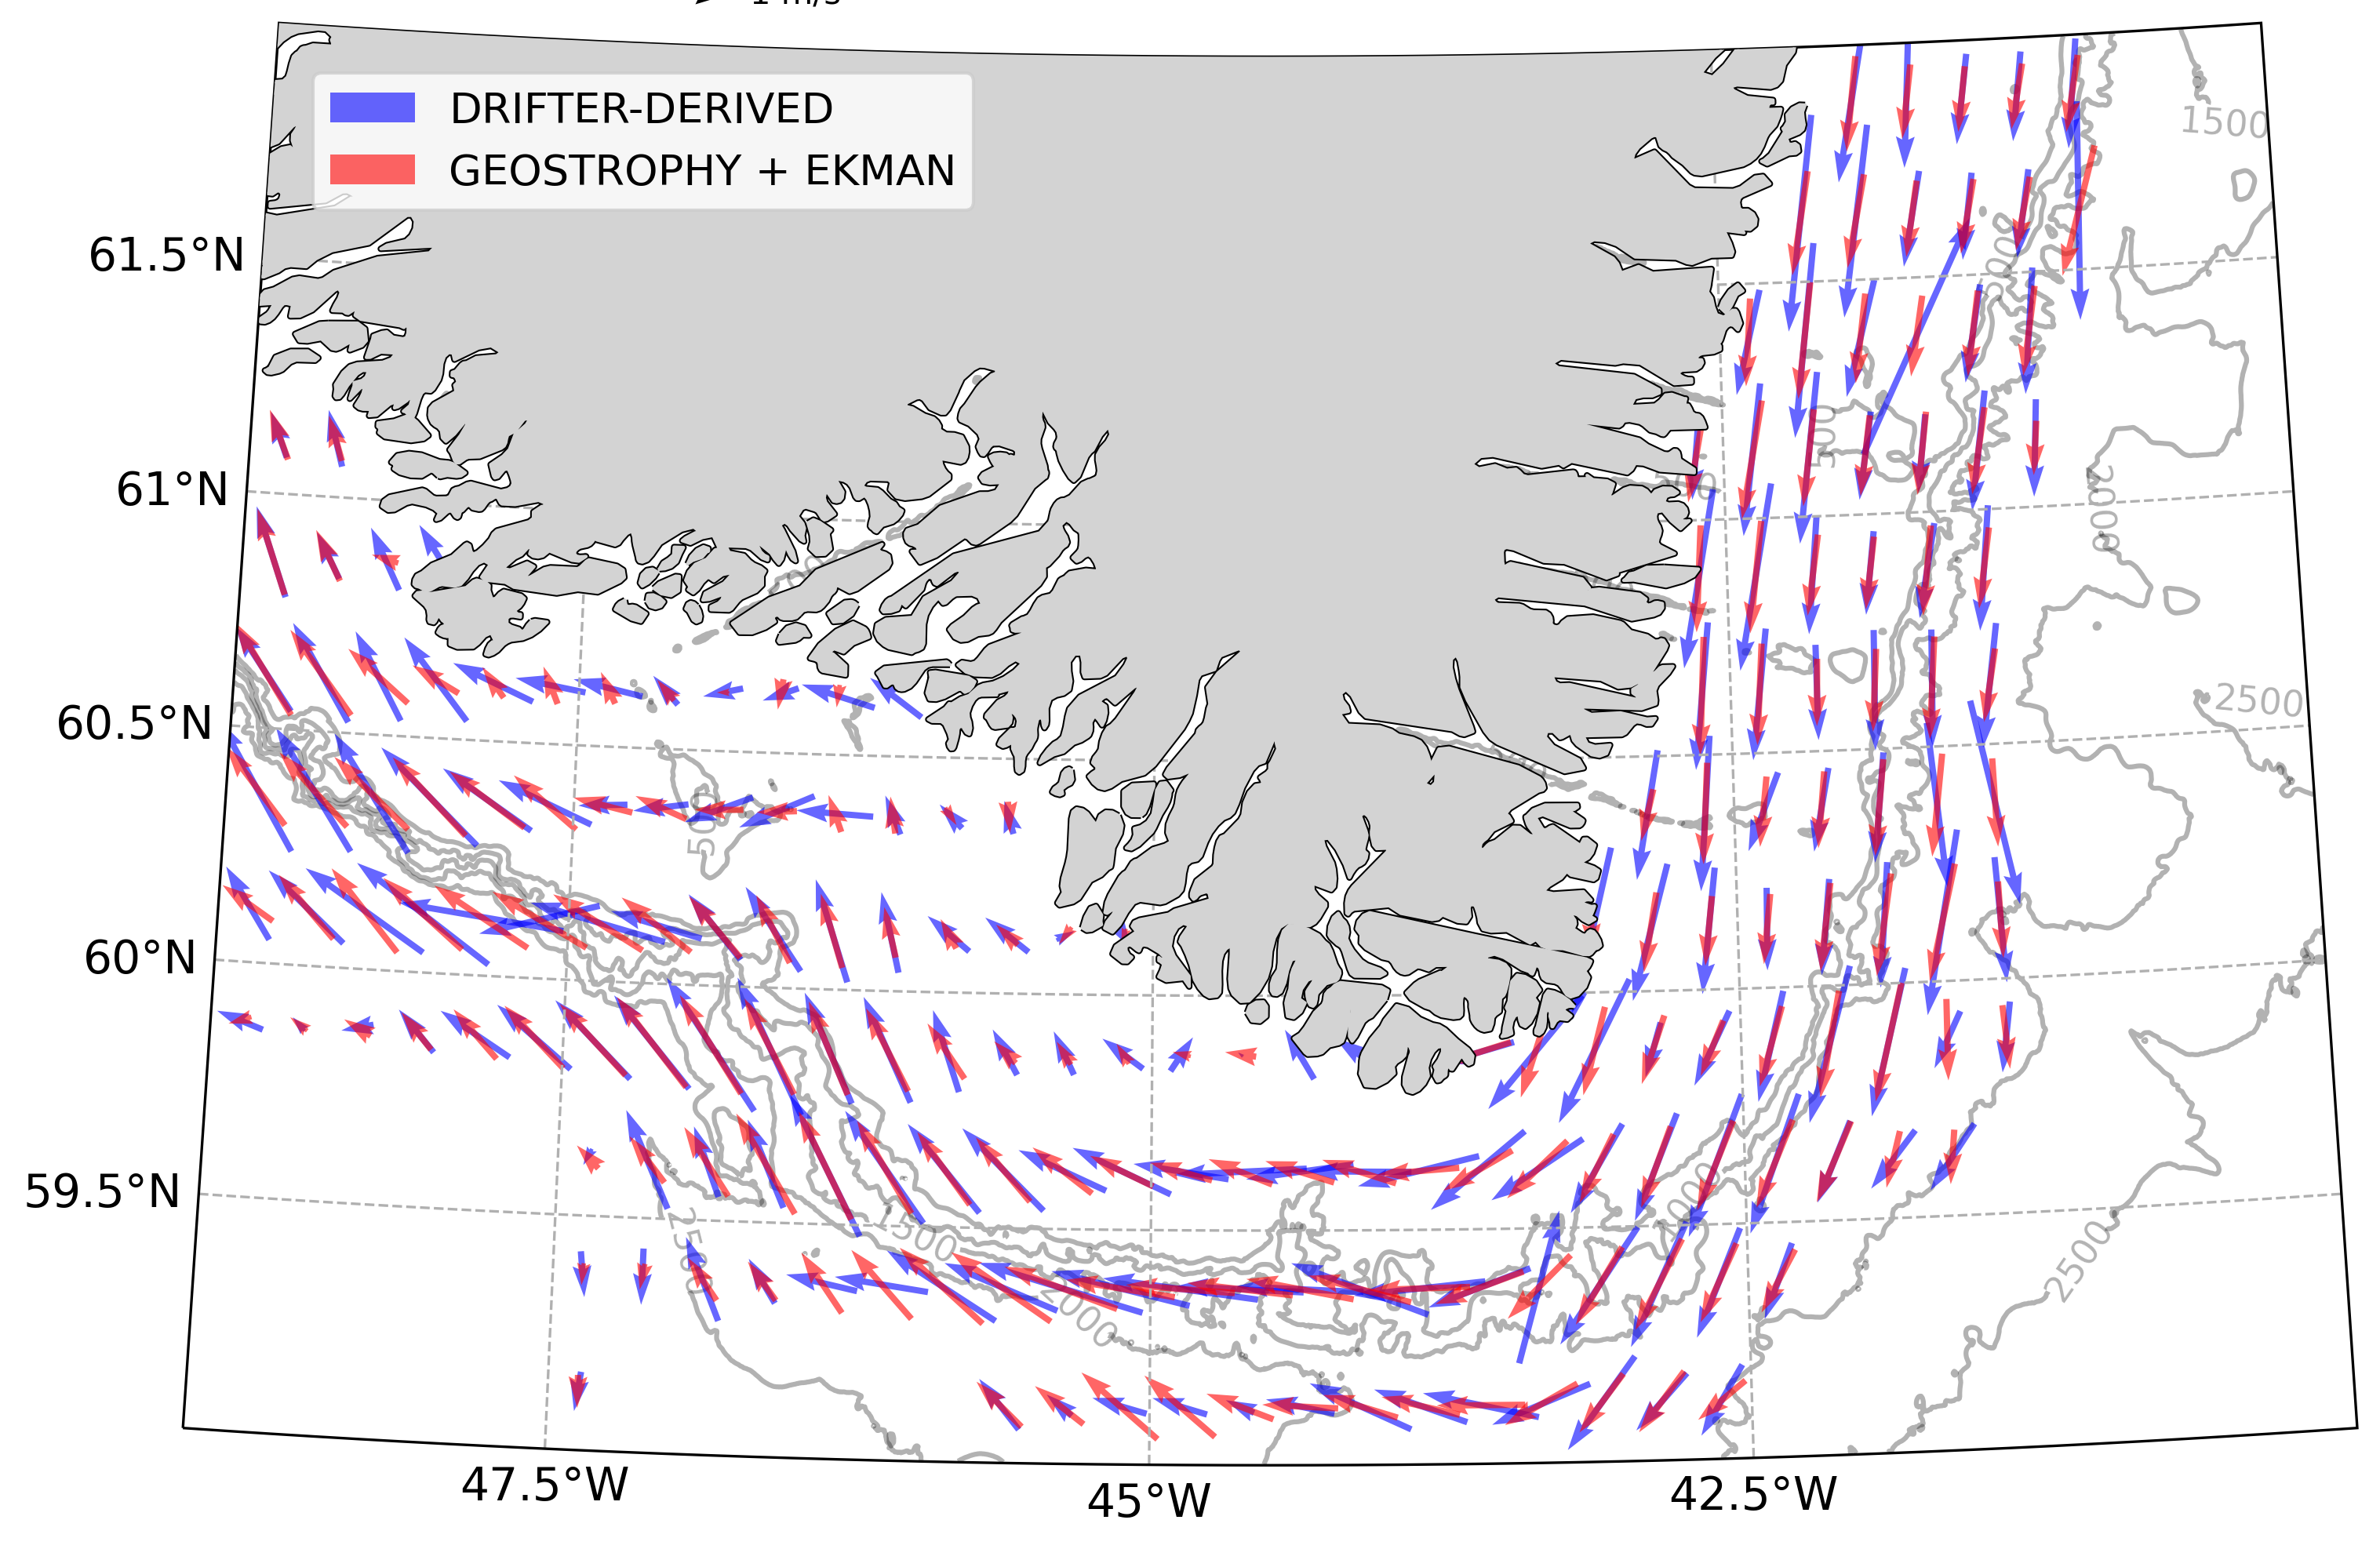

In [52]:
fig, ax, rect = createFigurewithProjection(figsize=(10, 10), nrows=1, ncols=1, bounds=[lonmin_study, lonmax_study, latmin_study, latmax_study])

ax.set_title('EULERIAN MEAN FLOW', fontsize=15)

shapeAxis(ax, rect, addCoastline=True)

CS = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.3, levels=np.arange(500, 3000, 500))
ax.clabel(CS, CS.levels, inline=True, fontsize=11, zorder=1)

Q = plt.quiver(X, Y, U_flow, V_flow, color='blue',  alpha=0.6, transform=ccrs.PlateCarree(), zorder=2, label='DRIFTER-DERIVED', scale=10, pivot='mid')

ax.quiverkey(Q, 0.25, 1.02, 1, r'1 m/s', transform=ccrs.PlateCarree(), zorder=4, coordinates='axes', labelpos='E', color='k', alpha=1)

plt.quiver(X, Y, U_flow_ek, V_flow_ek, color='red', alpha=0.6, transform=ccrs.PlateCarree(), zorder=2, label='GEOSTROPHY + EKMAN', scale=10, pivot='mid')


plt.legend(bbox_to_anchor=(0.05, 0.98), loc='upper left', fontsize=13)

In [48]:
drifterC = U_flow + 1j* V_flow
ekC = U_flow_ek + 1j* V_flow_ek

angle_ek = np.rad2deg(np.abs(np.angle(drifterC/ekC)))

diff_mod_ek = np.abs(ekC) / np.abs(drifterC) 

condiC_ek = ((np.abs(drifterC)>0.01)&(np.abs(ekC)>0.01))

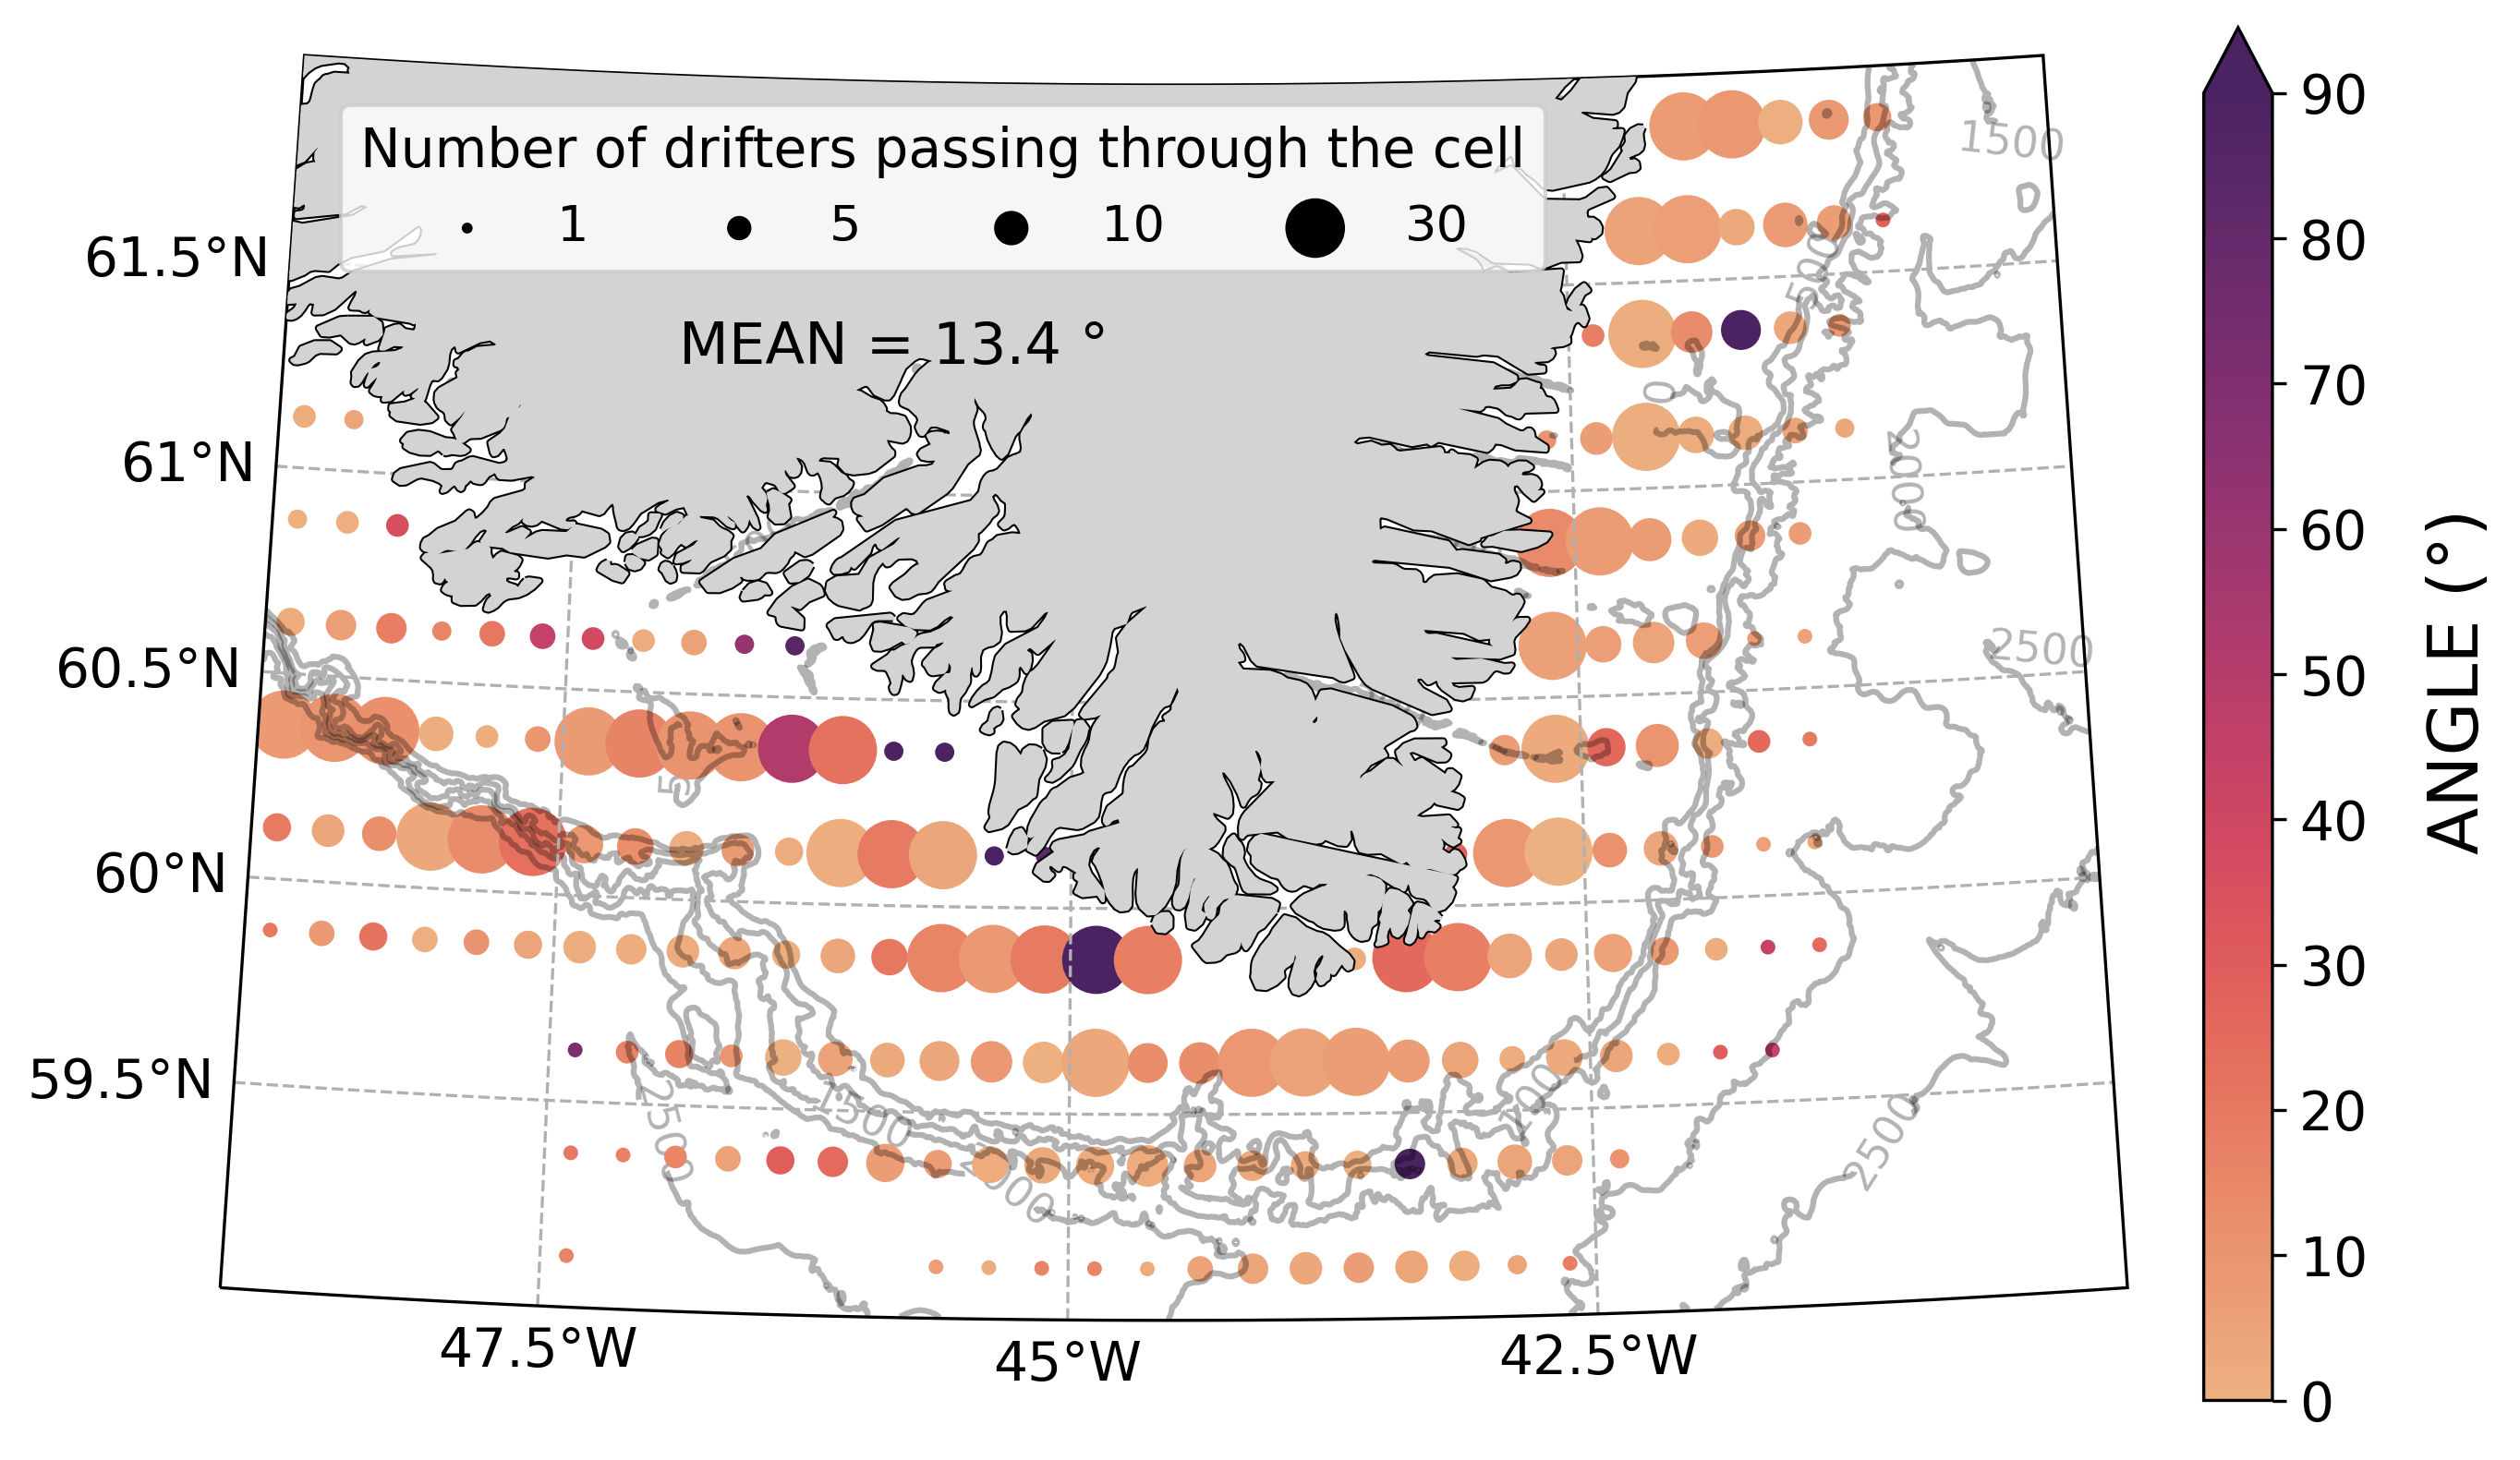

In [64]:
fig, ax, rect = createFigurewithProjection(figsize=(9, 9), nrows=1, ncols=1, bounds=[lonmin_study, lonmax_study, latmin_study, latmax_study])


dat = angle_ek
conditions = condiC_ek

ax.set_title('DIRECTION', fontsize=15)

shapeAxis(ax, rect, addCoastline=True)

CS = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.3, levels=np.arange(500, 3000, 500))
ax.clabel(CS, CS.levels, inline=True, fontsize=11, zorder=1)

meanangle = np.around(np.average(dat[conditions], weights=NB_drift[conditions]), 1)

ax.text(-47, 61.3, f'MEAN = {meanangle} °', transform=ccrs.PlateCarree(), fontsize=15)


pc = ax.scatter(X[conditions], Y[conditions], c=dat[conditions], s=NB_drift[conditions]*8, transform=ccrs.PlateCarree(), cmap='flare')
pc.set_clim(0, 90)


l1 = plt.scatter([],[], s=1*8, edgecolors='none', color='k')
l2 = plt.scatter([],[], s=5*8, edgecolors='none', color='k')
l3 = plt.scatter([],[], s=10*8, edgecolors='none', color='k')
l4 = plt.scatter([],[], s=30*8, edgecolors='none', color='k')
labels = ["1", "5", "10", "30"]

leg = ax.legend([l1, l2, l3, l4], labels, ncol=4, loc='upper left', bbox_to_anchor=(0.05, 0.98), fontsize=13, )
leg.set_title('Number of drifters passing through the cell',prop={'size':14})


cb = fig.colorbar(pc, extend='max', fraction=0.036, pad=0.040)
cb.ax.tick_params(labelsize=14)
cb.set_label('ANGLE (°)', labelpad=15, y=0.55, rotation=90, fontsize=18)

In [ ]:
U_ek

In [76]:
np.argmax(dat[conditions][Y[conditions] == 59.375])

16

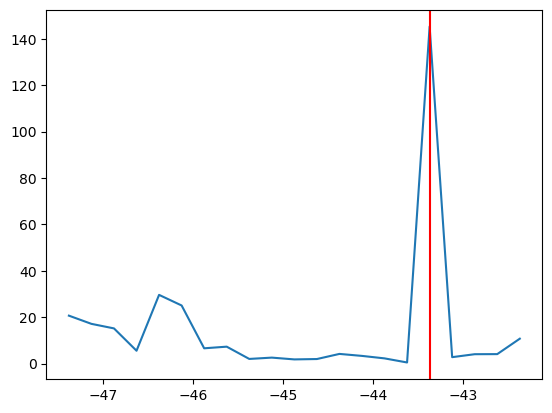

In [74]:
plt.plot(X[conditions][Y[conditions] == 59.375], dat[conditions][Y[conditions] == 59.375])
plt.axvline(-43.375, c='red')

In [67]:
Y[conditions] == 59.375

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

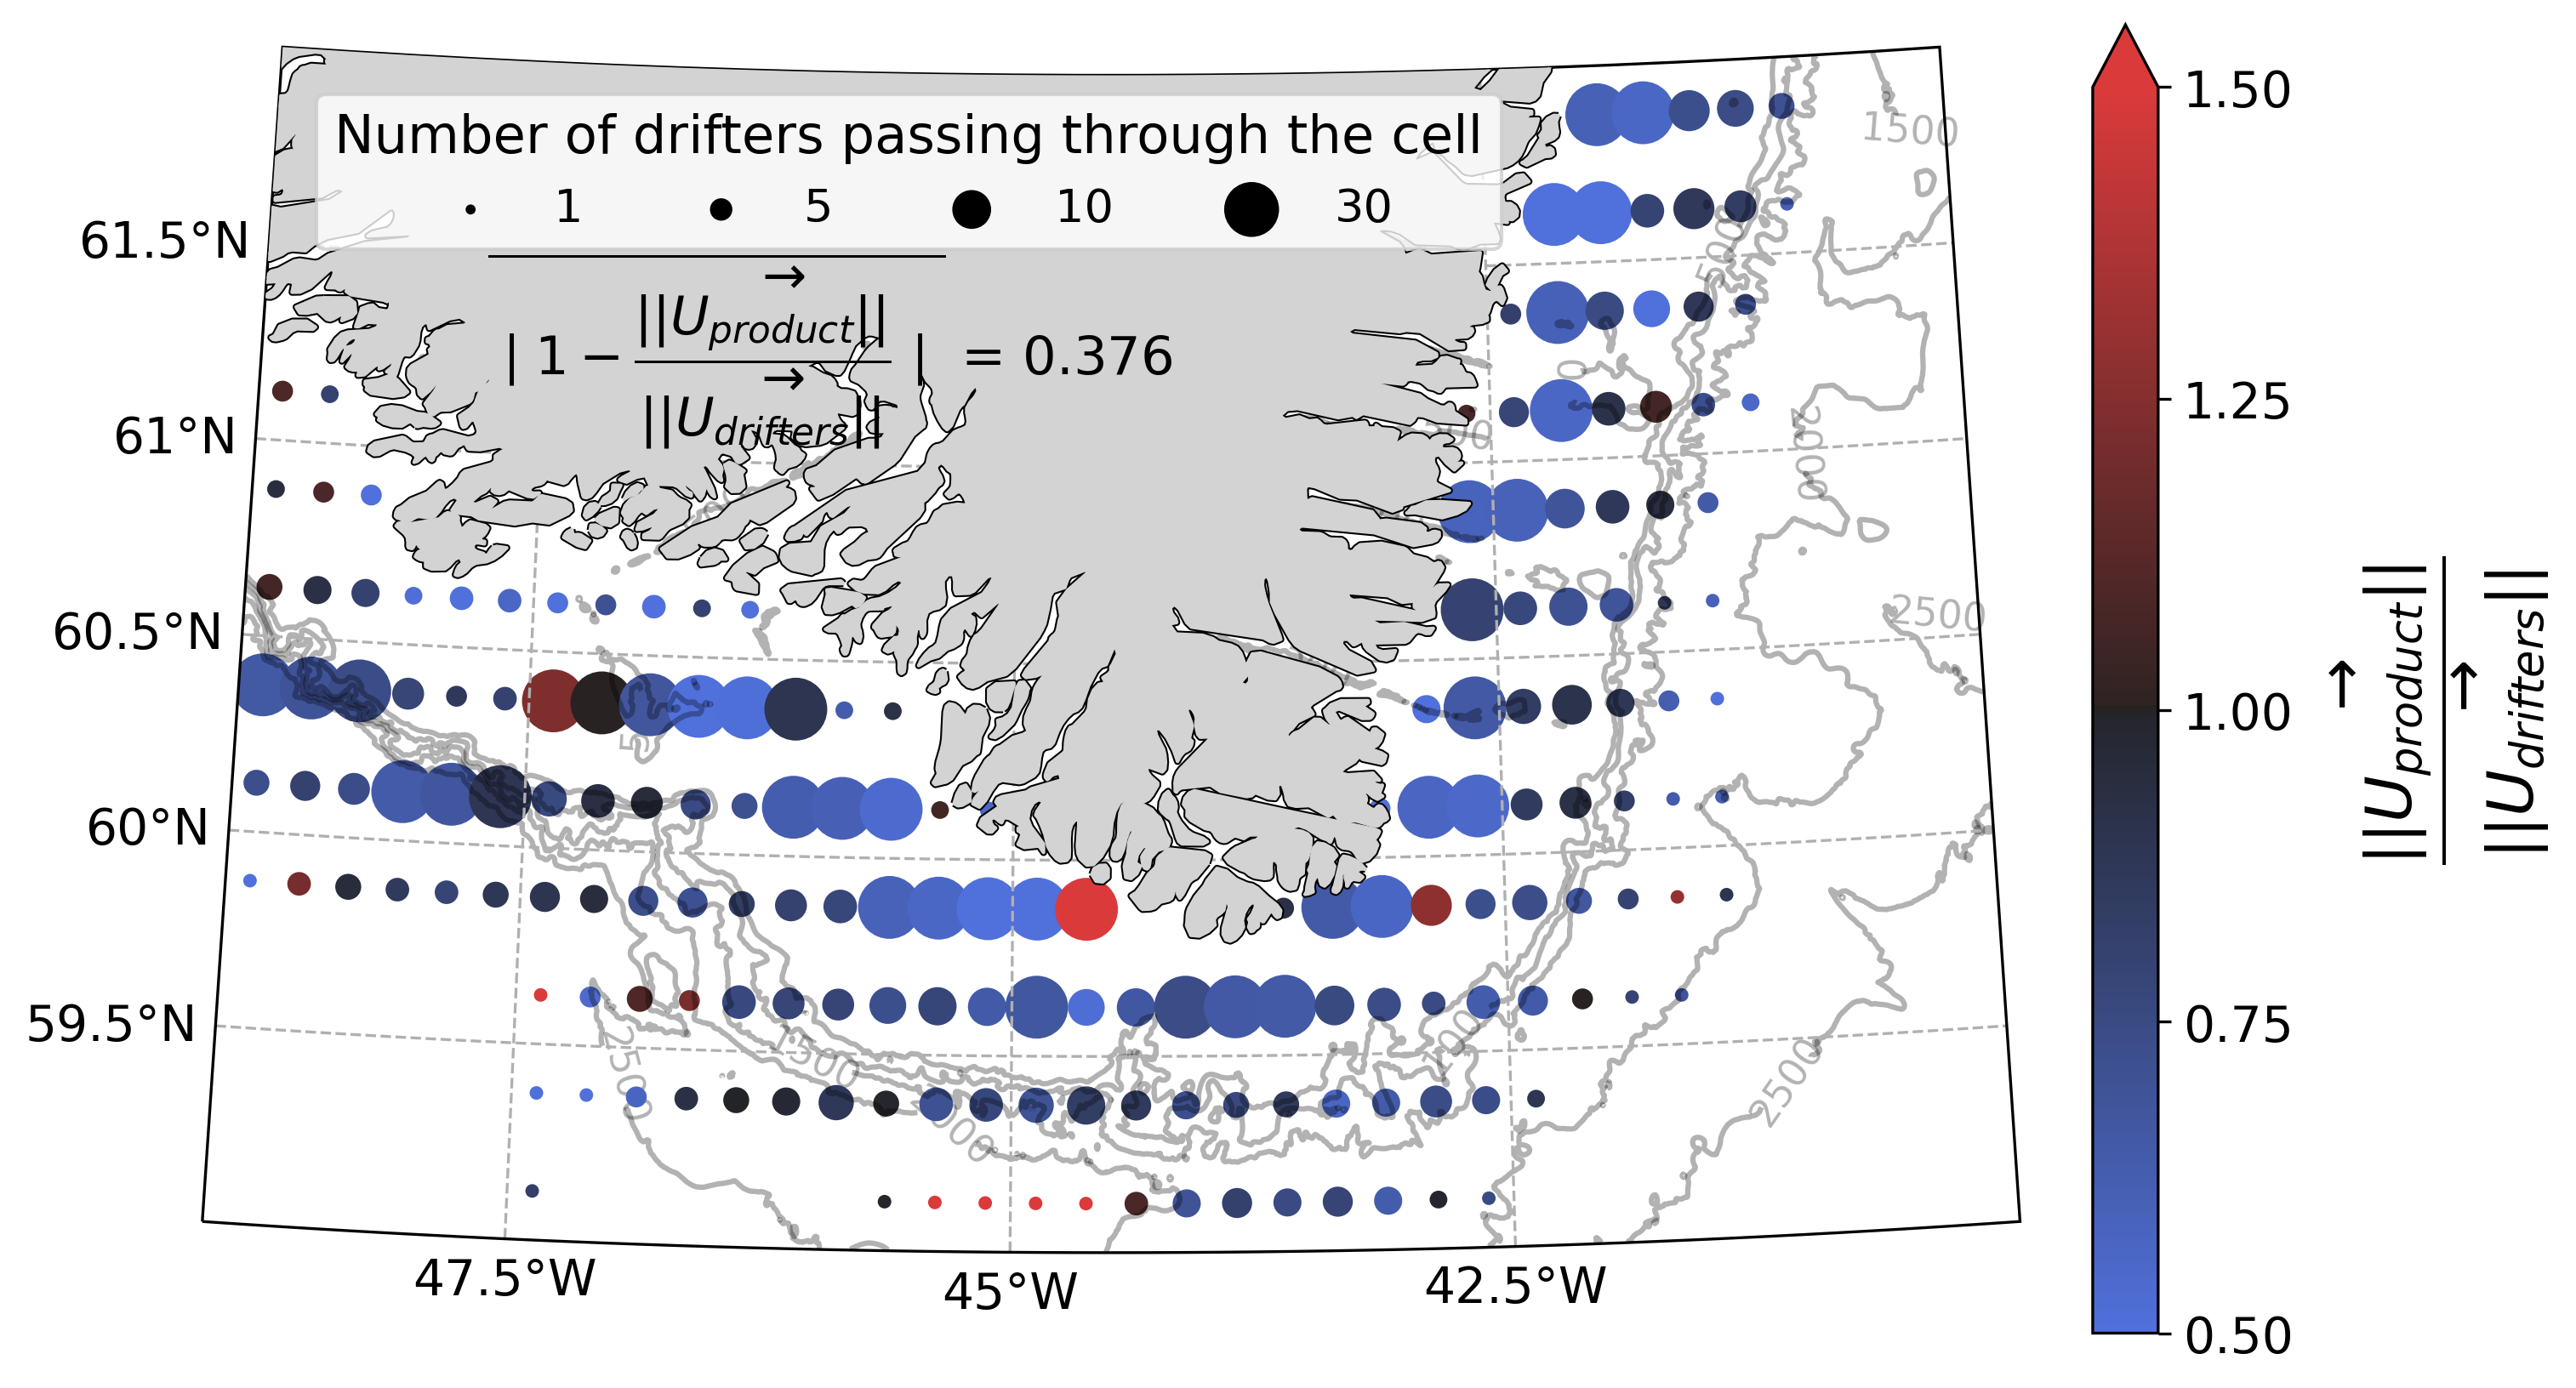

In [60]:
fig, ax, rect = createFigurewithProjection(figsize=(10, 10), nrows=1, ncols=1, bounds=[lonmin_study, lonmax_study, latmin_study, latmax_study])

#Colormaps
cm = sns.diverging_palette(260, 12, l=50, center="dark", as_cmap=True)

dat = diff_mod_ek
conditions = condiC_ek

ax.set_title('MAGNITUDE', fontsize=15)

shapeAxis(ax, rect, addCoastline=True)

CS = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.3, levels=np.arange(500, 3000, 500))
ax.clabel(CS, CS.levels, inline=True, fontsize=11, zorder=1)

avg = np.around(np.average(np.abs(dat[conditions]-1), weights=NB_drift[conditions]), 3)

ax.text(-47.8, 61.2, r'$ \overline{\mid 1-\dfrac{||\overrightarrow{U_{product}}||}{||\overrightarrow{U_{drifters}}||} \mid}$ = '+str(avg), transform=ccrs.PlateCarree(), fontsize=15)

pc = ax.scatter(X[conditions], Y[conditions], c=dat[conditions], s=NB_drift[conditions]*8, transform=ccrs.PlateCarree(), cmap=cm)
pc.set_clim(0.5, 1.5)

l1 = plt.scatter([],[], s=1*8, edgecolors='none', color='k')
l2 = plt.scatter([],[], s=5*8, edgecolors='none', color='k')
l3 = plt.scatter([],[], s=15*8, edgecolors='none', color='k')
l4 = plt.scatter([],[], s=30*8, edgecolors='none', color='k')
labels = ["1", "5", "10", "30"]

leg = ax.legend([l1, l2, l3, l4], labels, ncol=4, loc='upper left', bbox_to_anchor=(0.05, 0.98), fontsize=13, )
leg.set_title('Number of drifters passing through the cell',prop={'size':15})


cb = fig.colorbar(pc, extend='max', fraction=0.036, pad=0.040)
cb.set_ticks([0.5, 0.75, 1, 1.25, 1.5], fontsize=14)
cb.ax.tick_params(labelsize=14)
cb.set_label(r'$ \dfrac{||\overrightarrow{U_{product}}||}{||\overrightarrow{U_{drifters}}||} $', labelpad=10, y=0.5, rotation=90, fontsize=18)